# Análisis Predictivo — Determinantes Socioeconómicos y Mortalidad por ECV (nivel comunal)

In [1]:
pip install xlrd

Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install shap

In [3]:
!pip install xgboost

In [4]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.inspection import permutation_importance, PartialDependenceDisplay

try:
    from xgboost import XGBRegressor
    has_xgb = True
except Exception:
    XGBRegressor = None
    has_xgb = False

try:
    import shap
    has_shap = True
except Exception:
    shap = None
    has_shap = False

BASE = Path.cwd()
DATA_DIR = BASE / "data"
RESULTS_DIR = BASE / "results"
RESULTS_DIR.mkdir(exist_ok=True)


## 1) Funciones utilitarias para leer los archivos INE (tienen nombres de columnas variables)

In [5]:
def try_read_excel(path):
    # lee excel con varios engines si es necesario
    try:
        return pd.read_excel(path)
    except Exception:
        return pd.read_excel(path, engine='openpyxl')

def normalize_comuna_name(s):
    if pd.isna(s):
        return s
    return str(s).strip().upper().replace('Ñ','N').replace('Á','A').replace('É','E').replace('Í','I').replace('Ó','O').replace('Ú','U')

def find_best_column(df, candidates):
    # busca la primera columna que contenga el nombre de alguna de las palabras en candidates
    # pasan todos los nombres de columna a string ANTES de usar .lower()
    # para evitar el error si un nombre de columna es un numero
    cols = {str(c).lower(): c for c in df.columns}
    
    for cand in candidates:
        for col_lower, col_orig in cols.items():
            if cand.lower() in col_lower:
                return col_orig
    return None


## 2) Cargar y procesar cada tabla INE (1.2, 4.2, 7.3, 7.5)
# Se aplican heurísticas para detectar las columnas relevantes; revisa los nombres si no encuentra algo.

In [6]:
print("Procesando: 2.1 Poblacion y Dependencia...")

# apuntamos al archivo .xls que si existe en tu carpeta 'data'
p1_path = DATA_DIR / "1_2_POBLACION.xls"

# leer el archivo
try:
    # usamos pd.read_excel con el motor 'xlrd' y header=2 (fila 3 de Excel es el encabezado)
    poblacion_raw = pd.read_excel(
        p1_path, 
        engine='xlrd',
        header=2
    )
except Exception as e:
    print(f"Error al leer {p1_path}. Asegúrate que el header esta en la fila 3.")
    raise e

# detectar las columnas clave
col_comuna = find_best_column(poblacion_raw, ['comuna', 'nombre comuna'])
col_edad = find_best_column(poblacion_raw, ['edad', 'grupos de edad'])
col_total = find_best_column(poblacion_raw, ['total', 'poblacion', 'efectivamente censada'])

if col_comuna is None or col_edad is None or col_total is None:
     print("Columnas detectadas:", poblacion_raw.columns.tolist())
     raise ValueError("No se encontro 'Nombre Comuna', 'Grupos de Edad' o 'Poblacion Total'.")

# limpiar los datos base 
poblacion_proc = poblacion_raw[[col_comuna, col_edad, col_total]].copy()
poblacion_proc['Comuna'] = poblacion_proc[col_comuna].apply(normalize_comuna_name)
poblacion_proc[col_total] = pd.to_numeric(poblacion_proc[col_total], errors='coerce').fillna(0)
poblacion_proc[col_edad] = poblacion_proc[col_edad].astype(str).str.strip()
poblacion_proc['edad_norm'] = poblacion_proc[col_edad].str.lower().str.replace('á','a').str.replace('é','e').str.replace('í','i').str.replace('ó','o').str.replace('ú','u')

# extraer 'Poblacion_total' 
total_df = poblacion_proc[poblacion_proc['edad_norm'].str.contains('total comuna', na=False)].copy()
total_df = total_df[['Comuna', col_total]].rename(columns={col_total: 'Poblacion_total'})

# extraer 'Poblacion_mayor_65' 
categorias_mayores_norm = [
    '65 a 69', '70 a 74', '75 a 79', '80 a 84', 
    '85 a 89', '90 a 94', '95 a 99', '100 o mas'
]
filtro_mayores = poblacion_proc['edad_norm'].isin(categorias_mayores_norm)
mayor_df_raw = poblacion_proc[filtro_mayores].copy()
mayor_df = mayor_df_raw.groupby('Comuna')[col_total].sum().reset_index()
mayor_df = mayor_df.rename(columns={col_total: 'Poblacion_mayor_65'})

# unir ambos indicadores
poblacion = total_df.merge(mayor_df, on='Comuna', how='left')
poblacion['Poblacion_mayor_65'] = poblacion['Poblacion_mayor_65'].fillna(0)

# calcular el indice de dependencia
poblacion['Indice_dependencia_mayor'] = np.where(
    poblacion['Poblacion_total'] > 0,
    (poblacion['Poblacion_mayor_65'] / poblacion['Poblacion_total']) * 100,
    0
)

print("Poblacion (Total y Mayor de 65) cargada:", poblacion.shape)
poblacion.head()

Procesando: 2.1 Poblacion y Dependencia...
Poblacion (Total y Mayor de 65) cargada: (346, 4)


,Comuna,Poblacion_total,Poblacion_mayor_65,Indice_dependencia_mayor
0,ARICA,221364,24037,10.858586
1,CAMARONES,1255,206,16.414343
2,PUTRE,2765,235,8.499096
3,GENERAL LAGOS,684,99,14.473684
4,IQUIQUE,191468,17730,9.260033


In [7]:
print("Procesando: 2.2 Escolaridad...")
e_path = DATA_DIR / "4_2_EDUCACION.xls"

# 1. Leer el archivo (usamos header=2 porque ya vimos que ahí están los títulos)
try:
    educ_raw = pd.read_excel(
        e_path,
        engine='xlrd',
        header=2
    )
    # Estandarizamos nombres de columnas a mayúsculas y quitamos espacios extra
    educ_raw.columns = educ_raw.columns.str.strip().str.upper()
    
except Exception as e:
    print(f"Error al leer {e_path}. Asegúrate que el header esta en la Fila 3.")
    raise e

# 2. Definir columnas clave EXACTAS (según lo que imprimió tu error)
col_comuna = 'NOMBRE COMUNA'
col_grupo_edad = 'GRUPOS DE EDAD'
# ¡AQUÍ ESTABA EL ERROR! Agregamos la tilde en POBLACIÓN
col_total_pob = 'TOTAL POBLACIÓN EFECTIVAMENTE CENSADA' 

# Verificar existencia (Debug)
if col_comuna not in educ_raw.columns or col_grupo_edad not in educ_raw.columns:
     print("Columnas encontradas:", educ_raw.columns.tolist())
     raise ValueError(f"Faltan columnas. Buscamos '{col_comuna}' y '{col_grupo_edad}'")

# A veces la columna de población tiene ligeras variantes, tratamos de encontrarla si falla la exacta
if col_total_pob not in educ_raw.columns:
    # Buscar cualquier columna que tenga "TOTAL" y "POBLA"
    posibles = [c for c in educ_raw.columns if "TOTAL" in c and "POBLA" in c]
    if posibles:
        col_total_pob = posibles[0]
    else:
        raise ValueError("No se encontró la columna de Población Total.")

print(f"Usando columna de población: {col_total_pob}")

# 3. Mapeo de años de escolaridad
year_cols_map = {
    '1 AÑO DE ESCOLARIDAD': 1,
    '2 AÑOS DE ESCOLARIDAD': 2,
    '3 AÑOS DE ESCOLARIDAD': 3,
    '4 AÑOS DE ESCOLARIDAD': 4,
    '5 AÑOS DE ESCOLARIDAD': 5,
    '6 AÑOS DE ESCOLARIDAD': 6,
    '7 AÑOS DE ESCOLARIDAD': 7,
    '8 AÑOS DE ESCOLARIDAD': 8,
    '9 AÑOS DE ESCOLARIDAD': 9,
    '10 AÑOS DE ESCOLARIDAD': 10,
    '11 AÑOS DE ESCOLARIDAD': 11,
    '12 AÑOS DE ESCOLARIDAD': 12,
    '13 AÑOS DE ESCOLARIDAD': 13,
    '14 AÑOS DE ESCOLARIDAD': 14,
    '15 AÑOS DE ESCOLARIDAD': 15,
    '16 AÑOS DE ESCOLARIDAD': 16,
    '17 AÑOS DE ESCOLARIDAD': 17,
    '18 O MÁS AÑOS DE ESCOLARIDAD': 18
}

# 4. Limpieza y Cálculos
# Convertir a numérico
for col_name in year_cols_map.keys():
    if col_name in educ_raw.columns:
        educ_raw[col_name] = pd.to_numeric(educ_raw[col_name], errors='coerce').fillna(0)
        
educ_raw[col_total_pob] = pd.to_numeric(educ_raw[col_total_pob], errors='coerce').fillna(0)

# Calcular años totales acumulados
educ_raw['Total_Anios_Escolaridad_CALCULADO'] = 0
for col_name, year_value in year_cols_map.items():
    if col_name in educ_raw.columns:
        educ_raw['Total_Anios_Escolaridad_CALCULADO'] += (educ_raw[col_name] * year_value)

# Filtrar y normalizar
educ_proc = educ_raw[[col_comuna, col_grupo_edad, col_total_pob, 'Total_Anios_Escolaridad_CALCULADO']].copy()
educ_proc['Comuna'] = educ_proc[col_comuna].apply(normalize_comuna_name)
educ_proc[col_grupo_edad] = educ_proc[col_grupo_edad].astype(str).str.strip().str.lower()

# Filtrar por 'total comuna'
educ = educ_proc[educ_proc[col_grupo_edad].str.contains('total comuna', na=False)].copy()

# Calcular promedio final
educ['Promedio_escolaridad'] = np.where(
    educ[col_total_pob] > 0,
    educ['Total_Anios_Escolaridad_CALCULADO'] / educ[col_total_pob],
    0
)

educ = educ[['Comuna', 'Promedio_escolaridad']]

print("Escolaridad cargada exitosamente:", educ.shape)
educ.head()

Procesando: 2.2 Escolaridad...
Usando columna de población: TOTAL POBLACIÓN EFECTIVAMENTE CENSADA
Escolaridad cargada exitosamente: (346, 2)


,Comuna,Promedio_escolaridad
33,ARICA,9.043503
66,CAMARONES,8.726693
99,PUTRE,9.578662
132,GENERAL LAGOS,7.238304
165,IQUIQUE,9.685357


In [8]:
print("Procesando: 2.3 Acceso a agua potable...")
a_path = DATA_DIR / "7_3_VIVIENDA.xls"

# leer el archivo (motor 'xlrd' y 'header=2')
try:
    agua_raw = pd.read_excel(
        a_path,
        engine='xlrd',
        header=2 
    )
except Exception as e:
    print(f"Error al leer {a_path}. Asegúrate que el header esta en la fila 3.")
    raise e

# detectar las columnas clave
col_comuna = find_best_column(agua_raw, ['comuna', 'nombre comuna'])
col_total_viv = find_best_column(agua_raw, ['total viviendas'])
col_red_publica = find_best_column(agua_raw, ['red pública', 'red publica']) 

col_categoria = find_best_column(agua_raw, ['área', 'area']) 

if col_comuna is None or col_categoria is None or col_total_viv is None or col_red_publica is None:
    print("Columnas disponibles en 7_3_VIVIENDA.xls:", list(agua_raw.columns))
    raise ValueError("No se detecto 'NOMBRE COMUNA', 'ÁREA', 'TOTAL VIVIENDAS...' o 'Red pública'.")

# limpiar y filtrar
agua_proc = agua_raw[[col_comuna, col_categoria, col_total_viv, col_red_publica]].copy()
agua_proc['Comuna'] = agua_proc[col_comuna].apply(normalize_comuna_name)
agua_proc[col_total_viv] = pd.to_numeric(agua_proc[col_total_viv], errors='coerce').fillna(0)
agua_proc[col_red_publica] = pd.to_numeric(agua_proc[col_red_publica], errors='coerce').fillna(0)
agua_proc[col_categoria] = agua_proc[col_categoria].astype(str).str.strip().str.lower()

# filtrar por 'Total'
agua_proc = agua_proc[agua_proc[col_categoria].str.contains('total', na=False)].copy()

# calcular el porcentaje
agua_proc['Acceso_agua_potable_pct'] = np.where(
    agua_proc[col_total_viv] > 0,
    (agua_proc[col_red_publica] / agua_proc[col_total_viv]) * 100,
    0
)

# seleccionar columnas finales
agua_proc = agua_proc[['Comuna', 'Acceso_agua_potable_pct']].rename(columns={'Acceso_agua_potable_pct': 'Acceso_agua_potable'})

print("Agua potable cargada:", agua_proc.shape)
agua_proc.head()

Procesando: 2.3 Acceso a agua potable...
Agua potable cargada: (347, 2)


,Comuna,Acceso_agua_potable
0,PAIS,92.339938
3,ARICA,93.975438
6,CAMARONES,25.986079
9,PUTRE,66.296296
12,GENERAL LAGOS,28.899083


In [9]:
print("Procesando: 2.4 Hacinamiento...")
print("Cargando 'Hacinamiento_Comuna.xlsx' con el header=5...")

# nuevo archivo .xlsx
h_path = DATA_DIR / "Hacinamiento_Comuna.xlsx"

# leer el archivo
try:
    hacin_raw = pd.read_excel(
        h_path,
        engine='openpyxl',
        sheet_name="Vivienda Hacinamiento",
        header=5 # se cambia a la fila 6
    )
except Exception as e:
    print(f"Error al leer {h_path}. Asegurate que el header esta en la fila 6.")
    raise e

# 2. Definir las columnas clave (¡Basado en el debug!)
col_comuna = 'Unnamed: 1' # 'Comuna'
col_codigo = 'Unnamed: 2' # 'Codigo Comuna INE', lo usamos para filtrar
col_sin_hac = 'Unnamed: 5'
col_hac_medio = 'Unnamed: 8'
col_hac_critico = 'Unnamed: 11'
col_hac_ignorado = 'Unnamed: 17'

# para asegurnarnos de que estamos bien
if col_comuna not in hacin_raw.columns or col_codigo not in hacin_raw.columns or col_sin_hac not in hacin_raw.columns:
    print("--- ¡ERROR! NO SE ENCONTRARON LAS COLUMNAS 'Unnamed' ---")
    print("Columnas encontradas:", hacin_raw.columns.tolist())
    raise ValueError("No se encontraron las columnas 'Unnamed: 1', 'Unnamed: 2' o 'Unnamed: 5'.")

# limpiar y filtrar
# convertir todas las columnas de datos a numero
cols_to_numeric = [col_sin_hac, col_hac_medio, col_hac_critico, col_hac_ignorado]
for col in cols_to_numeric:
    hacin_raw[col] = pd.to_numeric(hacin_raw[col], errors='coerce').fillna(0)

# convertir la columna de codigo a numero para poder filtrar
hacin_raw[col_codigo] = pd.to_numeric(hacin_raw[col_codigo], errors='coerce')

# 5. filtro
# filtramos para quedarnos solo con las Comunas (codigos de 5 digitos > 1000)
hacin_proc = hacin_raw[hacin_raw[col_codigo] > 1000].copy()

# calcular el porcentaje de hacinamiento
# Total Viviendas = suma de todas las categorias
hacin_proc['Total_Viviendas_General'] = hacin_proc[col_sin_hac] + hacin_proc[col_hac_medio] + hacin_proc[col_hac_critico] + hacin_proc[col_hac_ignorado]
# Total Hacinadas = Medio + Critico
hacin_proc['Total_Viviendas_Hacinadas'] = hacin_proc[col_hac_medio] + hacin_proc[col_hac_critico]

# porcentaje
hacin_proc['Hacinamiento_pct'] = np.where(
    hacin_proc['Total_Viviendas_General'] > 0,
    (hacin_proc['Total_Viviendas_Hacinadas'] / hacin_proc['Total_Viviendas_General']) * 100,
    0
)

# seleccionar columnas finales y normalizar nombre, esta llnea ahora usara la columna 'Unnamed: 1' para los nombres)
hacin_proc['Comuna'] = hacin_proc[col_comuna].apply(normalize_comuna_name)
hacin_proc = hacin_proc[['Comuna', 'Hacinamiento_pct']].rename(columns={'Hacinamiento_pct': 'Hacinamiento'})

print("Hacinamiento cargado:", hacin_proc.shape)
hacin_proc.head()

Procesando: 2.4 Hacinamiento...
Cargando 'Hacinamiento_Comuna.xlsx' con el header=5...
Hacinamiento cargado: (346, 2)


,Comuna,Hacinamiento
19,ARICA,47.717409
20,CAMARONES,47.630332
21,PUTRE,47.109005
22,GENERAL LAGOS,46.099291
23,IQUIQUE,47.467016


## 3) Merge: crear la base comunal


In [10]:
print("Iniciando merge de bases INE...")

# Unimos los 4 dataframes que acabamos de crear
df = poblacion.merge(educ, on='Comuna', how='left') \
              .merge(agua_proc, on='Comuna', how='left') \
              .merge(hacin_proc, on='Comuna', how='left')

print("Merge completado. Filas:", df.shape[0])

# revisar filas nulas
print("Filas totales:", df.shape[0])
print("Missing por columna:\n", df.isna().sum())

# rellenar NA con mediana
df['Promedio_escolaridad'] = df['Promedio_escolaridad'].fillna(df['Promedio_escolaridad'].median())
df['Acceso_agua_potable'] = df['Acceso_agua_potable'].fillna(df['Acceso_agua_potable'].median())
df['Hacinamiento'] = df['Hacinamiento'].fillna(df['Hacinamiento'].median())
# rellenar la columna de dependencia que creamos en 2.1
df['Indice_dependencia_mayor'] = df['Indice_dependencia_mayor'].fillna(df['Indice_dependencia_mayor'].median())

# guardar base comunal inicial
df.to_csv(RESULTS_DIR / "base_comunal_ini.csv", index=False)
print("Base comunal del INE guardada.")
df.head()

Iniciando merge de bases INE...
Merge completado. Filas: 346
Filas totales: 346
Missing por columna:
 Comuna                      0
Poblacion_total             0
Poblacion_mayor_65          0
Indice_dependencia_mayor    0
Promedio_escolaridad        0
Acceso_agua_potable         0
Hacinamiento                2
dtype: int64
Base comunal del INE guardada.


,Comuna,Poblacion_total,Poblacion_mayor_65,Indice_dependencia_mayor,Promedio_escolaridad,Acceso_agua_potable,Hacinamiento
0,ARICA,221364,24037,10.858586,9.043503,93.975438,47.717409
1,CAMARONES,1255,206,16.414343,8.726693,25.986079,47.630332
2,PUTRE,2765,235,8.499096,9.578662,66.296296,47.109005
3,GENERAL LAGOS,684,99,14.473684,7.238304,28.899083,46.099291
4,IQUIQUE,191468,17730,9.260033,9.685357,98.110950,47.467016


## 4) Integrar DEIS (defunciones por ECV)

In [11]:
print("Procesando: 4. Integracion de datos DEIS (Mortalidad)...")
deis_path = DATA_DIR / "DEIS/deis_defunciones.csv"
deis = None
deis_agg = None # asegurarnos que la variable exista

if deis_path.exists():
    try:
        deis = pd.read_csv(deis_path, sep=';', encoding='latin1', low_memory=False)
        print("DEIS cargado desde csv (con sep=';')")
    except Exception as e:
        print(f"Error al leer el CSV del DEIS: {e}")
else:
    print("No se encontro archivo 'deis_defunciones.csv' en data/.")

if deis is not None:
    # buscar columnas
    col_cie = find_best_column(deis, ['diag1'])
    col_ano = find_best_column(deis, ['año'])
    
    # forzamos el nombre exacto de la columna 'COMUNA', ya que find_best_column se confunde con 'COD_COMUNA'
    col_com = 'COMUNA' 
    if col_com not in deis.columns:
        print(f"¡Error! No se encontro la columna exacta 'COMUNA'. Verificando columnas...")
        print(deis.columns.tolist())
        raise ValueError("No se encontro la columna de nombre 'COMUNA'")

    print(f"DEIS columnas detectadas: Causa={col_cie}, Comuna={col_com}, Año={col_ano}")
    
    if col_cie is None or col_ano is None:
        print("Columnas DEIS (DIAG1 o AÑO) no detectadas.")
    else:
        # filtro de Año (2017)
        deis[col_ano] = pd.to_numeric(deis[col_ano], errors='coerce')
        deis_2017 = deis[deis[col_ano] == 2017].copy()
        print(f"Filtrado por Año 2017: {deis_2017.shape[0]} defunciones encontradas.")

        # filtro de Causa (ECV 'I')
        deis_2017[col_cie] = deis_2017[col_cie].astype(str).str.strip().str.upper()
        mask_ecv = deis_2017[col_cie].str.startswith('I')
        deis_ecv = deis_2017[mask_ecv].copy()
        print(f"Filtrado por Causa 'I': {deis_ecv.shape[0]} defunciones de ECV encontradas.")
        
        # normalizar nombre de comuna (para el merge)
        deis_ecv['Comuna'] = deis_ecv[col_com].apply(normalize_comuna_name)
        
        # agrupar por comuna y contamos
        deis_agg = deis_ecv.groupby('Comuna').size().reset_index(name='Defunciones_ECV_2017')
        
        print("Procesamiento DEIS 2017 completado.")
        display(deis_agg.head())
else:
    print("No se cargaron datos DEIS.")

Procesando: 4. Integracion de datos DEIS (Mortalidad)...
DEIS cargado desde csv (con sep=';')
DEIS columnas detectadas: Causa=DIAG1, Comuna=COMUNA, Año=AÑO
Filtrado por Año 2017: 106388 defunciones encontradas.
Filtrado por Causa 'I': 28589 defunciones de ECV encontradas.
Procesamiento DEIS 2017 completado.


,Comuna,Defunciones_ECV_2017
0,AISEN,29
1,ALGARROBO,24
2,ALHUE,8
3,ALTO BIOBIO,7
4,ALTO DEL CARMEN,8


In [12]:
if 'deis_agg' in locals() and deis_agg is not None:
    print("Iniciando merge: Censo 2017 + DEIS 2017...")

    # limpiar 'df' de ejecuciones anteriores 
    cols_to_drop = [col for col in df.columns if 'Defunciones' in col or 'Tasa' in col]
    if cols_to_drop:
        print(f"Limpiando columnas antiguas: {cols_to_drop}")
        df = df.drop(columns=cols_to_drop)

    # merge con base comunal (el 'df' del Censo), esto ahora une 'ARICA' con 'ARICA'
    df = df.merge(deis_agg, on='Comuna', how='left')
    
    # rellenar NAs (donde no hubo muertes)
    df['Defunciones_ECV_2017'] = df['Defunciones_ECV_2017'].fillna(0).astype(int)

    # calcular tasa por 100k
    df['Tasa_mortalidad_ECV_100k'] = np.where(
        df['Poblacion_total'] > 0, 
        (df['Defunciones_ECV_2017'] / df['Poblacion_total']) * 100000, 
        np.nan
    )
    
    # rellenar NaN en la tasa (para comunas sin poblacion)
    df['Tasa_mortalidad_ECV_100k'] = df['Tasa_mortalidad_ECV_100k'].fillna(0)
    
    print("DEIS integrado y Tasa de Mortalidad 2017 calculada.")
    display(df.head())
else:
    print("Error: No se encontro el DataFrame 'deis_agg'. Ejecuta la celda anterior primero.")

Iniciando merge: Censo 2017 + DEIS 2017...
DEIS integrado y Tasa de Mortalidad 2017 calculada.


,Comuna,Poblacion_total,Poblacion_mayor_65,Indice_dependencia_mayor,Promedio_escolaridad,Acceso_agua_potable,Hacinamiento,Defunciones_ECV_2017,Tasa_mortalidad_ECV_100k
0,ARICA,221364,24037,10.858586,9.043503,93.975438,47.717409,298,134.619902
1,CAMARONES,1255,206,16.414343,8.726693,25.986079,47.630332,2,159.362550
2,PUTRE,2765,235,8.499096,9.578662,66.296296,47.109005,2,72.332731
3,GENERAL LAGOS,684,99,14.473684,7.238304,28.899083,46.099291,0,0.000000
4,IQUIQUE,191468,17730,9.260033,9.685357,98.110950,47.467016,259,135.270646


In [13]:
print("Guardando la base de datos final en la carpeta 'results'...")

if 'df' in locals():
    # usamos la variable RESULTS_DIR que definimos al inicio
    output_path = RESULTS_DIR / "base_final_con_mortalidad.csv"
    
    # guardar en csv
    df.to_csv(output_path, index=False)
    
    print(f"Base de datos final guardada en: {output_path}")
else:
    print("Error: No se encontro el DataFrame 'df' para guardar.")

Guardando la base de datos final en la carpeta 'results'...
Base de datos final guardada en: C:\Users\matia\Desktop\ProyectoAD\results\base_final_con_mortalidad.csv


## 5) EDA básico: estadísticas y gráficos


Generando gráficos exploratorios...


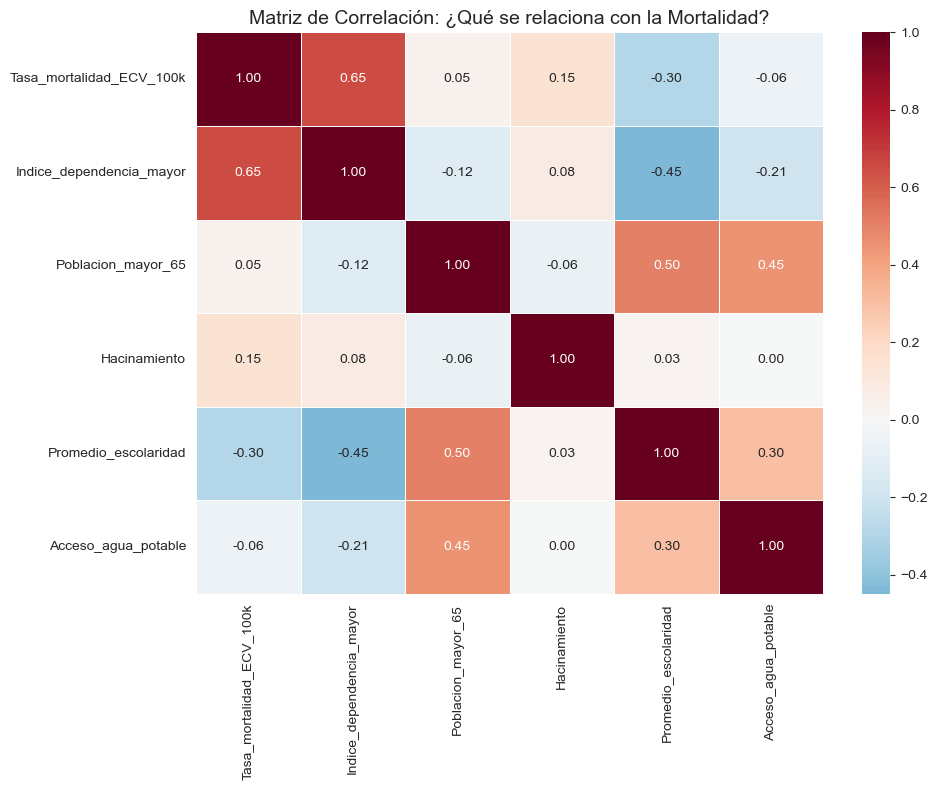

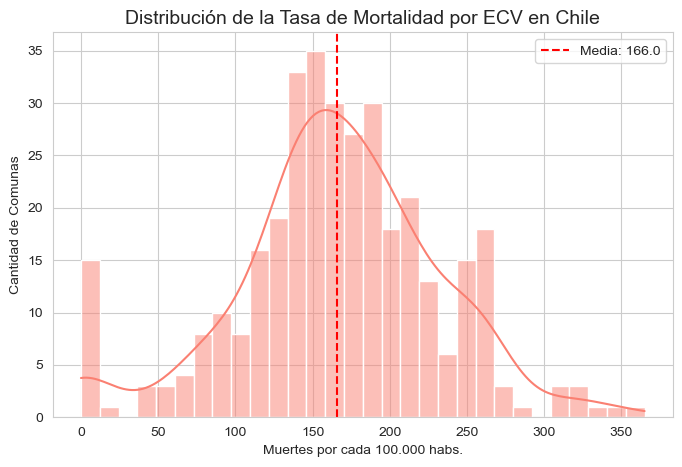

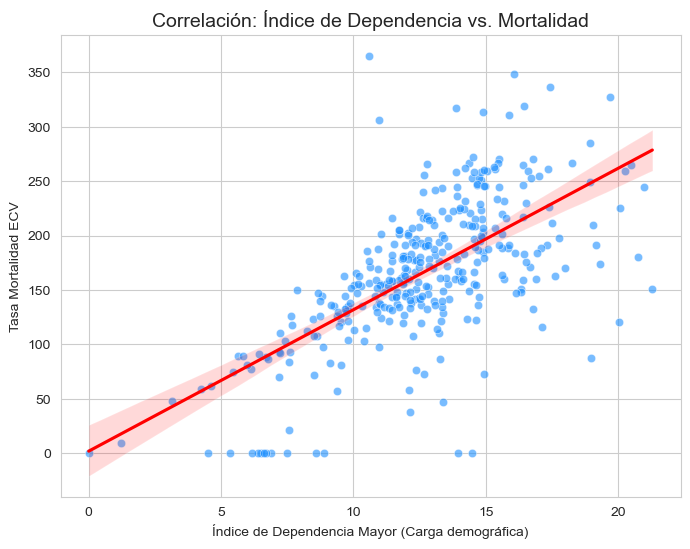

In [14]:
# estetica
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

print("Generando gráficos exploratorios...")

# matriz de correlacion
# muestra qué variables se mueven juntas, si el color es rojo fuerte, hay alta correlación positiva.
cols_interes = ['Tasa_mortalidad_ECV_100k', 'Indice_dependencia_mayor', 
                'Poblacion_mayor_65', 'Hacinamiento', 
                'Promedio_escolaridad', 'Acceso_agua_potable']

plt.figure(figsize=(10, 8))
corr_matrix = df[cols_interes].corr()
sns.heatmap(corr_matrix, annot=True, cmap='RdBu_r', center=0, fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación: ¿Qué se relaciona con la Mortalidad?", fontsize=14)
plt.tight_layout()
plt.savefig("matriz_correlacion.png", dpi=300, bbox_inches='tight')
plt.show()

# distribucion de la variable objetivo (histograma), sirve para ver si la mortalidad tiene una distribución normal (campana)
plt.figure(figsize=(8, 5))
sns.histplot(df['Tasa_mortalidad_ECV_100k'], bins=30, kde=True, color='salmon')
plt.title("Distribución de la Tasa de Mortalidad por ECV en Chile", fontsize=14)
plt.xlabel("Muertes por cada 100.000 habs.")
plt.ylabel("Cantidad de Comunas")
plt.axvline(df['Tasa_mortalidad_ECV_100k'].mean(), color='red', linestyle='--', label=f"Media: {df['Tasa_mortalidad_ECV_100k'].mean():.1f}")
plt.legend()
plt.show()

# Scatter Plot: La relacion mas fuerte (Edad vs Mortalidad)
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Indice_dependencia_mayor', y='Tasa_mortalidad_ECV_100k', alpha=0.6, color='dodgerblue')
sns.regplot(data=df, x='Indice_dependencia_mayor', y='Tasa_mortalidad_ECV_100k', scatter=False, color='red')
plt.title("Correlación: Índice de Dependencia vs. Mortalidad", fontsize=14)
plt.xlabel("Índice de Dependencia Mayor (Carga demográfica)")
plt.ylabel("Tasa Mortalidad ECV")
plt.show()

## 6) Modelado: Random Forest

Modelo               | R2 Score   | RMSE      
----------------------------------------------
Regresión Lineal     | 0.4492     | 47.7792
Random Forest        | 0.4801     | 46.4176
XGBoost              | 0.4139     | 49.2849


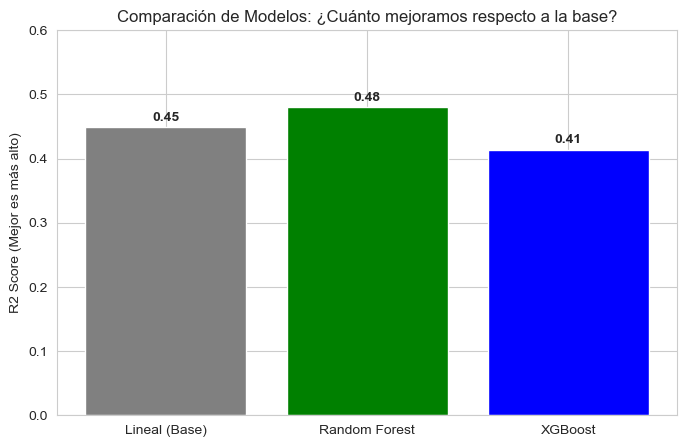

In [15]:
# definicion de datos
features = ['Poblacion_mayor_65', 'Indice_dependencia_mayor', 
            'Promedio_escolaridad', 'Acceso_agua_potable', 'Hacinamiento']
target = 'Tasa_mortalidad_ECV_100k'

X = df[features]
y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# --- A. Modelo Base (Baseline) ---
# se usa una regresion lineal simple para comparar
base_model = LinearRegression()
base_model.fit(X_train, y_train)
y_pred_base = base_model.predict(X_test)
r2_base = r2_score(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

# --- B. Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# --- C. XGBoost ---
if has_xgb:
    xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
    xgb_model.fit(X_train, y_train)
    y_pred_xgb = xgb_model.predict(X_test)
    r2_xgb = r2_score(y_test, y_pred_xgb)
    rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
else:
    r2_xgb, rmse_xgb = 0, 0

# comparativa de resultados
print(f"{'Modelo':<20} | {'R2 Score':<10} | {'RMSE':<10}")
print("-" * 46)
print(f"{'Regresión Lineal':<20} | {r2_base:.4f}     | {rmse_base:.4f}")
print(f"{'Random Forest':<20} | {r2_rf:.4f}     | {rmse_rf:.4f}")
if has_xgb:
    print(f"{'XGBoost':<20} | {r2_xgb:.4f}     | {rmse_xgb:.4f}")

# graficos de comparacion
modelos = ['Lineal (Base)', 'Random Forest']
r2s = [r2_base, r2_rf]
if has_xgb:
    modelos.append('XGBoost')
    r2s.append(r2_xgb)

plt.figure(figsize=(8, 5))
plt.bar(modelos, r2s, color=['gray', 'green', 'blue'])
plt.title("Comparación de Modelos: ¿Cuánto mejoramos respecto a la base?")
plt.ylabel("R2 Score (Mejor es más alto)")
plt.ylim(0, 0.6)
for i, v in enumerate(r2s):
    plt.text(i, v + 0.01, f"{v:.2f}", ha='center', fontweight='bold')
plt.show()

## 7) Importancia de variables y SHAP


Generando gráficos de resultados...


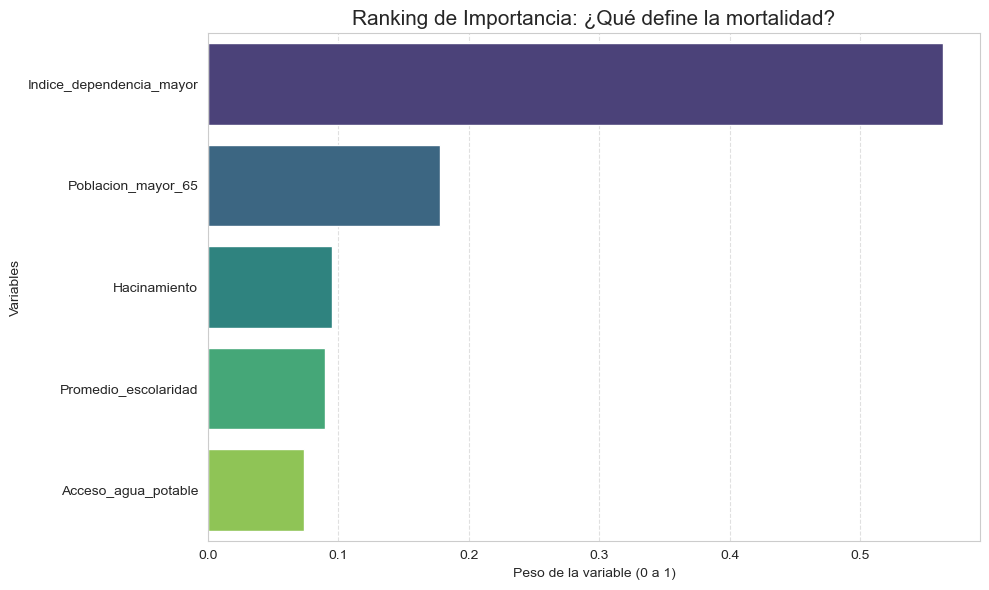

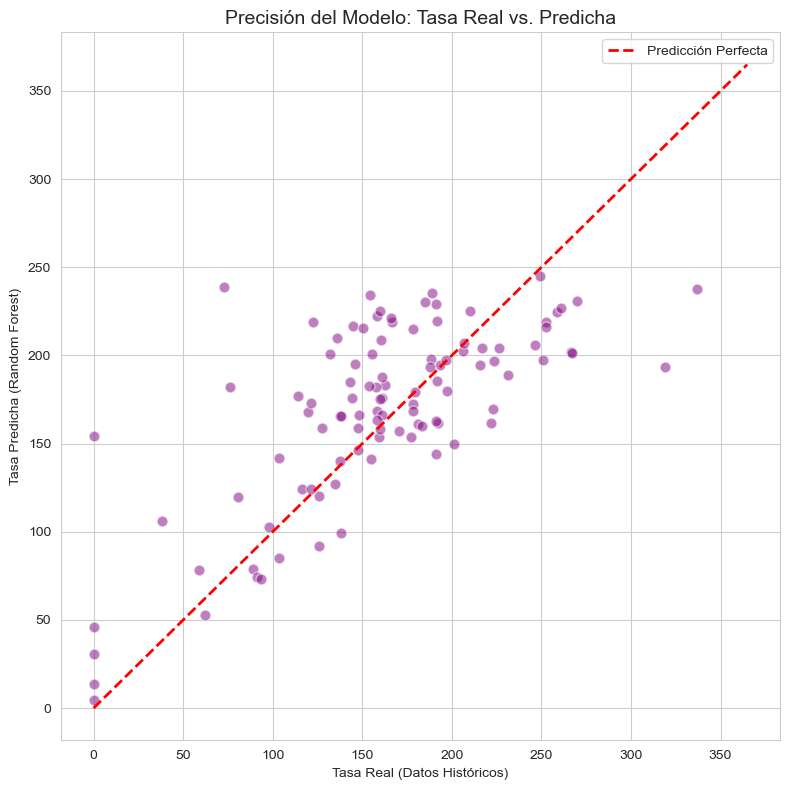

In [16]:
# asegurarse que el modelo rf ya fue entrenado
if 'rf_model' not in locals():
    print("¡Error! Debes entrenar el modelo en la celda 6 primero.")
else:
    print("Generando gráficos de resultados...")

    # grafico de barras: Importancia de Variables (Feature Importance)
    importances = rf_model.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [X.columns[i] for i in indices]

    plt.figure(figsize=(10, 6))
    
    # hue=names y legend=False para evitar advertencias de Seaborn
    sns.barplot(x=importances[indices], y=names, hue=names, palette="viridis", legend=False)
    
    plt.title("Ranking de Importancia: ¿Qué define la mortalidad?", fontsize=15)
    plt.xlabel("Peso de la variable (0 a 1)")
    plt.ylabel("Variables")
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("ranking_importancia.png", dpi=300, bbox_inches='tight')
    plt.show()

    # grafico de prediccion: Realidad vs. Modelo
    plt.figure(figsize=(8, 8))
    
    plt.scatter(y_test, y_pred_rf, alpha=0.5, color='purple', edgecolor='w', s=60)
    
    # linea de identidad
    m_min, m_max = y.min(), y.max()
    plt.plot([m_min, m_max], [m_min, m_max], 'r--', lw=2, label='Predicción Perfecta')
    
    plt.title("Precisión del Modelo: Tasa Real vs. Predicha", fontsize=14)
    plt.xlabel("Tasa Real (Datos Históricos)")
    plt.ylabel("Tasa Predicha (Random Forest)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# 8) Gráfico SHAP

Generando gráfico SHAP (Beeswarm)...


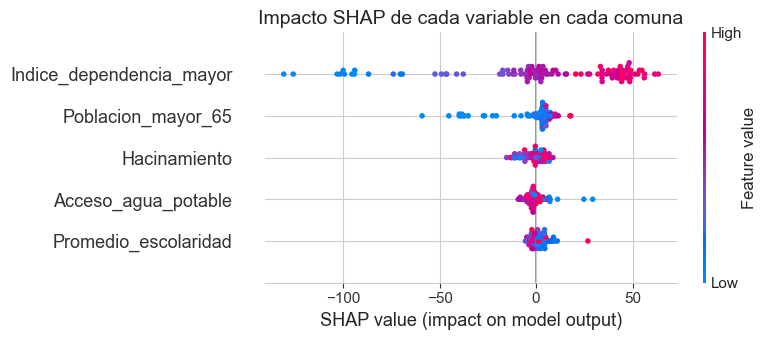

In [20]:
if 'has_shap' in globals() and has_shap:
    try:
        print("Generando gráfico SHAP (Beeswarm)...")
        explainer = shap.TreeExplainer(rf_model)
        shap_values = explainer.shap_values(X_test)
            
        plt.figure()
        shap.summary_plot(shap_values, X_test, show=False)
        plt.title("Impacto SHAP de cada variable en cada comuna", fontsize=14)
        plt.tight_layout()
        plt.show()
    except Exception as e:
        print(f"No se pudo generar SHAP: {e}")
else:
    print("La librería SHAP no esta instalada.")